This Notebook explores methods to calibrate an acceleromater and gyroscope built into an IMU. This looks at the offset of both the accelerometer and gyroscope and the sensitivity of the accelerometer. The noise covariance matrix is also calculated for use in a Kalman filter. Temperature effects are shown in plots and accounted for. Finally, gaps in the rotation space are shown and additional angles are suggested to improve calibration.

In [1]:
import os
import json
import itertools
from functools import partial
from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from scipy import special, stats, optimize
import matplotlib.pyplot as plt

import tools

# Make matplotlib interractive in jupyter
%matplotlib widget

In [2]:
def get_file_statistics(file: str, cut_time: int = 2, plot: bool = False, lowpass=150) -> tuple[np.ndarray, np.ndarray]:
    """Extract statistics from a file containing IMU data.

    Args:
        file (str): Path to the JSON file containing accelerometer and gyroscope data.
        cut_time (int, optional): Time in seconds to remove from the beginning of the data. Defaults to 2.
        plot (bool, optional): If True, the function will plot the IMU data. Defaults to False.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the mean and covariance of the combined measurements.
    """
    accelerometer, gyroscope, sample_rate, temperature, temperature_sample_rate = \
        tools.read_data_file(file, lowpass=lowpass, settle_time=cut_time)

    # Plot the data if requested
    if plot:
        if temperature is not None:
            tools.plot_data(accelerometer, gyroscope, sample_rate, file, temperature, temperature_sample_rate)
        else:
            tools.plot_data(accelerometer, gyroscope, sample_rate, file)
    
    # Combine into a single measurement vector
    measurements = np.hstack((accelerometer, gyroscope))
    # Calculate mean and covariance
    if temperature is not None:
        return np.mean(measurements, axis=0), np.cov(measurements, rowvar=False), np.mean(temperature), np.std(temperature), sample_rate
    else:
        return np.mean(measurements, axis=0), np.cov(measurements, rowvar=False), None, None, sample_rate

The following block will read in each file in the specified folder and then calculate the mean and covariance matrix for the accelerometer and gyroscope. It also calculated the mean and STD for the temperature sensor (if it exists, otherwise it will be None).

In [3]:
cal_path = os.path.join('..', 'tmp', 'cal_5v')
# cal_path = os.path.join('..', 'tmp', 'cal_3v3')
# Get list of all JSON files in the path 
file_names = sorted([os.path.join(cal_path, f) for f in os.listdir(cal_path) if f.endswith('.json')])

a_mean_list = []
g_mean_list = []
rotation_list = []
cov_list = []
t_mean_list = []
files = []
for file in file_names:
    mean_f, cov_f, mean_t, std_t, sample_rate = get_file_statistics(file, plot=False, cut_time=2, lowpass=150)
    if np.isnan(mean_t):
        continue
    rotation = tools.Location3d.get_rotation_from_mean_accelerometer(mean_f[:3])
    rotation_list.append(rotation)
    a_mean_list.append(mean_f[:3])
    g_mean_list.append(mean_f[3:])
    cov_list.append(cov_f)
    t_mean_list.append(mean_t)
    files.append(file)
g_mean_list = np.array(g_mean_list)
t_mean_list = np.array(t_mean_list)

print(f"Number of measurements: {len(a_mean_list)}")

Number of measurements: 55


X: 0.00010 * T + -0.00635
Y: -0.00006 * T + -0.00496
Z: -0.00026 * T + 0.01501


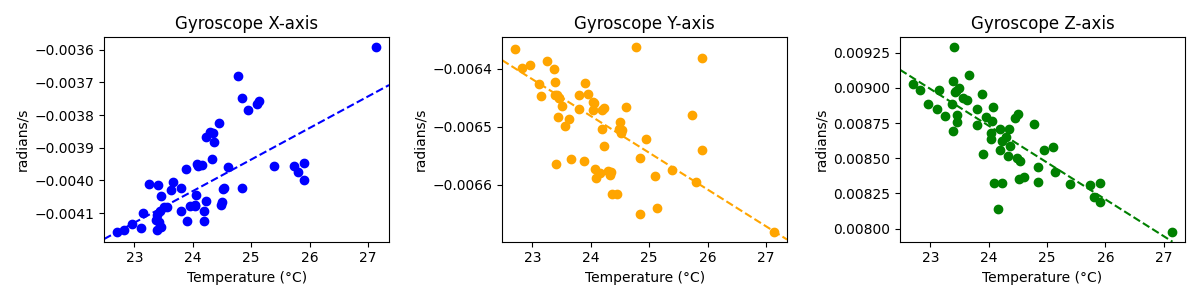

In [4]:
# Calibration the gyroscope channels first, taking into account the temperature
USE_THEIL_SEN = True
if USE_THEIL_SEN:
    g_x_slope, g_x_offset, _, _ = stats.theilslopes(g_mean_list[:, 0], t_mean_list)
    g_y_slope, g_y_offset, _, _ = stats.theilslopes(g_mean_list[:, 1], t_mean_list)
    g_z_slope, g_z_offset, _, _ = stats.theilslopes(g_mean_list[:, 2], t_mean_list)
else:
    g_x_slope, g_x_offset = np.polyfit(t_mean_list, g_mean_list[:, 0], 1)
    g_y_slope, g_y_offset = np.polyfit(t_mean_list, g_mean_list[:, 1], 1)
    g_z_slope, g_z_offset = np.polyfit(t_mean_list, g_mean_list[:, 2], 1)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# X axis plot
ax[0].plot(t_mean_list, g_mean_list[:, 0], 'o', color='blue')
ax[0].axline((t_mean_list[0], g_x_slope * t_mean_list[0] + g_x_offset), slope=g_x_slope, color='blue', linestyle='--')
ax[0].set_title('Gyroscope X-axis')
ax[0].set_xlabel('Temperature (°C)')
ax[0].set_ylabel('radians/s')

# Y axis plot
ax[1].plot(t_mean_list, g_mean_list[:, 1], 'o', color='orange')
ax[1].axline((t_mean_list[0], g_y_slope * t_mean_list[0] + g_y_offset), slope=g_y_slope, color='orange', linestyle='--')
ax[1].set_title('Gyroscope Y-axis')
ax[1].set_xlabel('Temperature (°C)')
ax[1].set_ylabel('radians/s')

# Z axis plot
ax[2].plot(t_mean_list, g_mean_list[:, 2], 'o', color='green')
ax[2].axline((t_mean_list[0], g_z_slope * t_mean_list[0] + g_z_offset), slope=g_z_slope, color='green', linestyle='--')
ax[2].set_title('Gyroscope Z-axis')
ax[2].set_xlabel('Temperature (°C)')
ax[2].set_ylabel('radians/s')

plt.tight_layout()

# Print the slope and offset for each axis
print(f'X: {g_x_slope:.5f} * T + {g_x_offset:.5f}')
print(f'Y: {g_y_slope:.5f} * T + {g_y_offset:.5f}')
print(f'Z: {g_z_slope:.5f} * T + {g_z_offset:.5f}')

plt.show()

final_gyroscope_offset = np.array([g_x_offset, g_y_offset, g_z_offset])
final_gyroscope_temperature_slope = np.array([g_x_slope, g_y_slope, g_z_slope])

In [5]:
def run_accelerometer_calibration(a_mean_list, sensitivity_type='single'):
    def _simulate_norm(a_mean_list, c):
        if sensitivity_type == 'single':
            sensitivity = c[0]
        elif sensitivity_type == 'individual':
            sensitivity = c[:3]
        elif sensitivity_type == 'full':
            sensitivity = c[:9].reshape(-1, 3)
        offset = c[-3:]

        errors = []
        for a_mean in a_mean_list:
            if sensitivity_type == 'full':
                v = np.linalg.norm(a_mean @ sensitivity - offset)
            else:
                v = np.linalg.norm(a_mean * sensitivity - offset)
            errors.append(v - tools.GRAVITY)

        return np.sqrt(np.mean(np.array(errors)**2))

    # Get a partial function from simulate vector where we fix the acceleration vectors
    simulate_norm_partial = partial(_simulate_norm, a_mean_list)

    # Calculate number of values in the vector
    if sensitivity_type == 'single':
        init_x = [1]
        bounds = [(0.8, 1.2)]
    elif sensitivity_type == 'individual':
        init_x = [1, 1, 1]
        bounds = [(0.8, 1.2)]*3
    elif sensitivity_type == 'full':
        init_x = np.eye(3).flatten().tolist()
        bounds = [
            (0.8, 1.2), (-0.2, 0.2), (-0.2, 0.2),
            (-0.2, 0.2), (0.8, 1.2), (-0.2, 0.2),
            (-0.2, 0.2), (-0.2, 0.2), (0.8, 1.2)
        ]
    # Add initial offsets to the end
    init_x += [0, 0, 0]
    bounds += [(-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.2)]

    # Run the optimizer using
    np.random.seed(52)
    res = optimize.minimize(simulate_norm_partial, init_x, tol=1e-7, bounds=bounds)
    if not res.success:
        print(res)
        raise Exception('Optimization failed')
    # Get the output results
    if sensitivity_type == 'single':
        sensitivity = res.x[0]
    elif sensitivity_type == 'individual':
        sensitivity = res.x[:3]
    elif sensitivity_type == 'full':
        sensitivity = res.x[:9].reshape(-1, 3)
    offset = res.x[-3:]
    return sensitivity, offset


sensitivity_type = 'full'
sensitivity, offset = run_accelerometer_calibration(a_mean_list, sensitivity_type=sensitivity_type)
print(f'Accelerometer Sensitivity:')
print(f'{sensitivity}')
print(f'Accelerometer Offset: {offset}')
final_accelerometer_offset = offset
final_accelerometer_sensitivity = sensitivity

Accelerometer Sensitivity:
[[ 1.00790690e+00 -2.04310293e-04 -4.49994646e-03]
 [ 1.74847079e-03  1.01342996e+00  8.13660431e-04]
 [-2.67326173e-03  2.67024314e-03  1.00443380e+00]]
Accelerometer Offset: [-0.09051361 -0.08485822  0.04487958]


In [6]:
def generate_combinations(a_mean_list, n, max_combinations):
    num_combinations = special.comb(len(a_mean_list), n, exact=True)
    limited_combinations = min(num_combinations, max_combinations)
    
    if limited_combinations == num_combinations:
        # You can safely use itertools.combinations since it won't exceed max_combinations
        combinations = list(itertools.combinations(a_mean_list, n))
    else:
        # Randomly sample unique combinations without replacement
        combinations = []
        seen_combinations = set()
        
        while len(combinations) < limited_combinations:
            random_indices = tuple(sorted(np.random.choice(len(a_mean_list), n, replace=False)))
            if random_indices not in seen_combinations:
                seen_combinations.add(random_indices)
                combinations.append([a_mean_list[i] for i in random_indices])

    return combinations


def bootstrap(a_mean_list, n, sensitivity_type):
    combinations = generate_combinations(a_mean_list, n, max_combinations=200)
    # Parallelize the for loop
    parallel = True
    if parallel:
        results = Parallel(n_jobs=-1)(delayed(run_accelerometer_calibration)(sub_a_mean_list, sensitivity_type) for sub_a_mean_list in combinations)
    else:
        results = [run_accelerometer_calibration(sub_a_mean_list, sensitivity_type) for sub_a_mean_list in combinations]

    sensitivity_list, offset_list = zip(*results)
    sensitivity_list = np.array(sensitivity_list)
    offset_list = np.array(offset_list)
    
    return (
        np.mean(sensitivity_list, axis=0), np.std(sensitivity_list, axis=0),
        np.mean(offset_list, axis=0), np.std(offset_list, axis=0),
    )

RUN_BOOTSTRAP = False
if RUN_BOOTSTRAP:
    recording_counts = list(sorted(set(np.round(np.linspace(max(10, len(a_mean_list)/2), len(a_mean_list), 10)).astype(int))))
    # recording_counts = list(range(max(len(a_mean_list)-10, 10), len(a_mean_list)))
    offset_mean_list = []
    offset_std_list = []
    sensitivity_mean_list = []
    sensitivity_std_list = []
    for n in recording_counts:
        print(f"Running {n} files...")
        sensitivity_mean, sensitivity_std, offset_mean, offset_std = bootstrap(a_mean_list, n, sensitivity_type)
        offset_mean_list.append(offset_mean)
        offset_std_list.append(offset_std)
        sensitivity_mean_list.append(sensitivity_mean)
        sensitivity_std_list.append(sensitivity_std)
    recording_counts = np.array(recording_counts)
    offset_mean_list = np.array(offset_mean_list)
    offset_std_list = np.array(offset_std_list)
    sensitivity_mean_list = np.array(sensitivity_mean_list)
    sensitivity_std_list = np.array(sensitivity_std_list)

    # Expand dimensions to make plotting easier, so the output shape is always the same
    if sensitivity_type == 'single':
        sensitivity_mean_list = np.expand_dims(sensitivity_mean_list, axis=1)
        sensitivity_std_list = np.expand_dims(sensitivity_std_list, axis=1)
    if sensitivity_type != 'full':
        sensitivity_mean_list = np.expand_dims(sensitivity_mean_list, axis=2)
        sensitivity_std_list = np.expand_dims(sensitivity_std_list, axis=2)

In [7]:
def plot_mean_std_lines(ax, recording_counts: np.ndarray, mean_list: np.ndarray, std_list: np.ndarray,
                        final_value: np.ndarray, title: str, ylabel: str) -> None:
    """Plot mean lines with shaded regions representing +/- 2 standard deviations.
    
    Args:
        ax: Axis object to plot on.
        recording_counts (np.ndarray): Array of recording counts.
        mean_list (np.ndarray): Array of mean values.
        std_list (np.ndarray): Array of standard deviation values.
        final_value (np.ndarray): Final value to plot as a horizontal line.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
    """
    ax.plot(recording_counts, mean_list, label='Mean')
    ax.fill_between(recording_counts, mean_list - 2 * std_list, mean_list + 2 * std_list,
                    alpha=0.2, label='2*STD')
    ax.axhline(final_value, color='r', label=ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid()


if RUN_BOOTSTRAP:
    # Plot line for mean with shaded regions +/- 2 STD for the accelerometer offset
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle('Offset Bootstrap Across Recordings')
    for n, axis_name in enumerate(['X', 'Y', 'Z']):
        plot_mean_std_lines(
            ax[n], recording_counts, offset_mean_list[:, n], offset_std_list[:, n], final_accelerometer_offset[n],
            title=axis_name, ylabel='Final Offset'
        )
    fig.tight_layout()
    fig.show()

    if sensitivity_type == 'single':
        fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
        ax = np.array([[ax]])
    elif sensitivity_type == 'individual':
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        ax = np.expand_dims(ax, axis=1)
    elif sensitivity_type == 'full':
        fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle('Sensitivity Bootstrap Across Recordings')

    for i in range(3):
        for j in range(3):
            if sensitivity_type == 'single' and not (i == 0 and j == 0):
                continue
            elif sensitivity_type == 'individual' and j > 0:
                continue

            if sensitivity_type == 'single':
                final_sensitivity = final_accelerometer_sensitivity
            elif sensitivity_type == 'individual':
                final_sensitivity = final_accelerometer_sensitivity[i]
            elif sensitivity_type == 'full':
                final_sensitivity = final_accelerometer_sensitivity[i, j]

            plot_mean_std_lines(
                ax[i, j], recording_counts, sensitivity_mean_list[:, i, j], sensitivity_std_list[:, i, j], final_sensitivity,
                title='', ylabel='Final Sensitivity'
            )
    fig.tight_layout()
    fig.show()

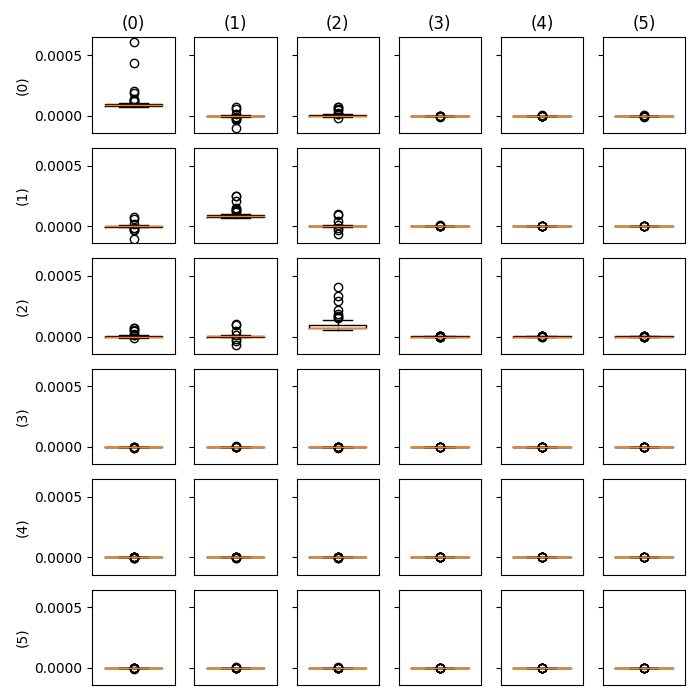

In [8]:
# TODO need to update this so that it is done AFTER the other calibrations, since temperature calibrations can impact covariance
# Calculate the covariance matrix for the accelerometer/gyroscope combined
cov_list = np.array(cov_list)
# Create a grid of plots, where each boxplot is the element in the matrix
fig, axes = plt.subplots(cov_list.shape[1], cov_list.shape[2], figsize=(7, 7), sharey=True)
# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(cov_list.shape[1]):
    for j in range(cov_list.shape[2]):
        # Create the box plot for the data at position (i, j)
        data = [matrix[i, j] for matrix in cov_list]
        axes[i, j].boxplot(data, widths=0.7)
        if i == 0:
            axes[i, j].set_title(f'({j})')
        if j == 0:    
            axes[i, j].set_ylabel(f'({i})')
        axes[i, j].set_xticks([])  # Remove x-axis labels
plt.tight_layout()
plt.show()

# Get the average covariance matrix
final_r_covariance = np.mean(cov_list, axis=0)

In [9]:
# Create a dictionary of all the final calibration values
final_calibration = {
    'R': final_r_covariance.tolist(),
    'accelerometer_sensitivity': final_accelerometer_sensitivity.tolist(),
    'accelerometer_offset': final_accelerometer_offset.tolist(),
    'gyroscope_offset': final_gyroscope_offset.tolist(),
    'gyroscope_temperature_slope': final_gyroscope_temperature_slope.tolist(),
}

# Save the calibration values to a JSON file
with open('calibration.json', 'w') as f:
    json.dump(final_calibration, f, indent=4)

# Run calibration on gyroscope and accelerometer data
calibrated_gyroscope = []
calibrated_accelerometer = []
for a, g, t in zip(a_mean_list, g_mean_list, t_mean_list):
    c_a, c_g = tools.apply_calibration(a, g, t, final_calibration)
    calibrated_gyroscope.append(c_g)
    calibrated_accelerometer.append(c_a)

Calibrated gyroscope:
X: 0.000968 ± 0.005355 (-0.0095, 0.0115) dps
Y: -0.000433 ± 0.003740 (-0.0078, 0.0069) dps
Z: -0.001030 ± 0.009397 (-0.0194, 0.0174) dps

Two worst measurements for X-axis (dps):


,X,Y,Z,File,Temperature
43,0.015925,0.009673,0.012409,cal_49.json,24.775691
29,0.011663,-0.006616,-0.004218,cal_36.json,24.843610


Two worst measurements for Y-axis (dps):


,X,Y,Z,File,Temperature
25,-0.008604,0.012673,-0.002447,cal_32.json,25.906428
43,0.015925,0.009673,0.012409,cal_49.json,24.775691


Two worst measurements for Z-axis (dps):


,X,Y,Z,File,Temperature
32,0.003705,-0.005019,-0.031373,cal_39.json,24.159856
36,0.004388,-0.006852,0.023343,cal_42.json,23.410156


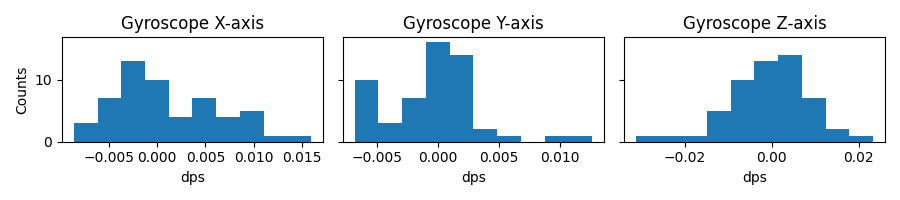

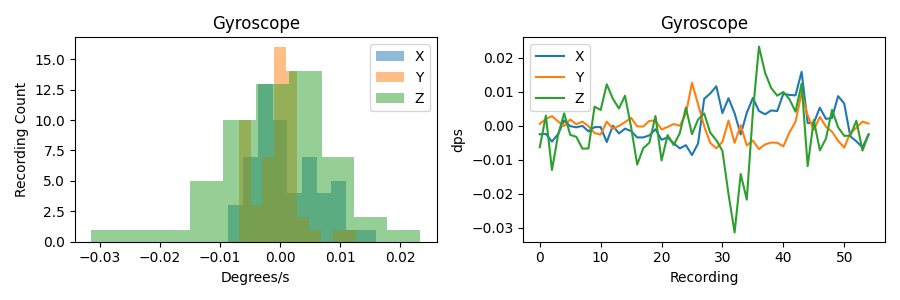

In [10]:
# Implement the calibration for the gyroscope and show the results
# Convert to degrees per second for plotting
calibrated_gyroscope = np.array(calibrated_gyroscope) * 180 / np.pi

# Print mean +/- STD (95% CI)for the calibrated gyroscope
print('Calibrated gyroscope:')
print(f'X: {np.mean(calibrated_gyroscope[:, 0]):.6f} ± {np.std(calibrated_gyroscope[:, 0]):.6f} ('
      f'{np.mean(calibrated_gyroscope[:, 0]) - 1.96 * np.std(calibrated_gyroscope[:, 0]):.4f}, '
      f'{np.mean(calibrated_gyroscope[:, 0]) + 1.96 * np.std(calibrated_gyroscope[:, 0]):.4f}) dps')
print(f'Y: {np.mean(calibrated_gyroscope[:, 1]):.6f} ± {np.std(calibrated_gyroscope[:, 1]):.6f} ('
      f'{np.mean(calibrated_gyroscope[:, 1]) - 1.96 * np.std(calibrated_gyroscope[:, 1]):.4f}, '
      f'{np.mean(calibrated_gyroscope[:, 1]) + 1.96 * np.std(calibrated_gyroscope[:, 1]):.4f}) dps')
print(f'Z: {np.mean(calibrated_gyroscope[:, 2]):.6f} ± {np.std(calibrated_gyroscope[:, 2]):.6f} '
      f'({np.mean(calibrated_gyroscope[:, 2]) - 1.96 * np.std(calibrated_gyroscope[:, 2]):.4f}, '
      f'{np.mean(calibrated_gyroscope[:, 2]) + 1.96 * np.std(calibrated_gyroscope[:, 2]):.4f}) dps')

# Create a dataframe with the calibrated gyroscope data and filename
calibrated_gyroscope_df = pd.DataFrame(calibrated_gyroscope, columns=['X', 'Y', 'Z'])
calibrated_gyroscope_df['File'] = [os.path.basename(f) for f in files]
calibrated_gyroscope_df['Temperature'] = t_mean_list
# Display top two worst measurements for each axis (based on absolute value)
print()
print('Two worst measurements for X-axis (dps):')
display(calibrated_gyroscope_df.sort_values(by=['X'], ascending=False, key=lambda x: np.abs(x)).head(2))
print('Two worst measurements for Y-axis (dps):')
display(calibrated_gyroscope_df.sort_values(by=['Y'], ascending=False, key=lambda x: np.abs(x)).head(2))
print('Two worst measurements for Z-axis (dps):')
display(calibrated_gyroscope_df.sort_values(by=['Z'], ascending=False, key=lambda x: np.abs(x)).head(2))

# Plot box plots for the calibration gyroscope for each axis
labels = ['X', 'Y', 'Z']
fig, axs = plt.subplots(1, 3, figsize=(9, 2), sharey=True)
for i, (ax, label, axis_data) in enumerate(zip(axs, labels, calibrated_gyroscope.T)):
    # ax.boxplot(axis_data)
    ax.hist(axis_data, bins=10)
    ax.set_xlabel('dps')
    if i == 0:
        ax.set_ylabel('Counts')
    # ax.set_xticks([])  # Remove x-axis ticks since there's only one box per subplot
    ax.set_title(f'Gyroscope {label}-axis')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

# Plot the histogram and time series for the calibrated gyroscope
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].hist(calibrated_gyroscope[:, 0], bins=10, label='X', alpha=0.5)
axs[0].hist(calibrated_gyroscope[:, 1], bins=10, label='Y', alpha=0.5)
axs[0].hist(calibrated_gyroscope[:, 2], bins=10, label='Z', alpha=0.5)
axs[0].set_title('Gyroscope')
axs[0].set_xlabel('Degrees/s')
axs[0].set_ylabel('Recording Count')
axs[0].legend()
axs[1].plot(calibrated_gyroscope[:, 0], label='X')
axs[1].plot(calibrated_gyroscope[:, 1], label='Y')
axs[1].plot(calibrated_gyroscope[:, 2], label='Z')
axs[1].set_title('Gyroscope')
axs[1].set_xlabel('Recording')
axs[1].set_ylabel('dps')
axs[1].legend()
plt.tight_layout()
plt.show()


# Calibrated gyroscope:
# X: 0.000968 ± 0.005355 (-0.0095, 0.0115) dps
# Y: -0.000433 ± 0.003740 (-0.0078, 0.0069) dps
# Z: -0.001030 ± 0.009397 (-0.0194, 0.0174) dps

Error: -0.05432 ± 0.0744 (original)
Mean norm: 9.8034
RMS error: 0.0058
Error: -1.263e-05 ± 0.005784 (full)


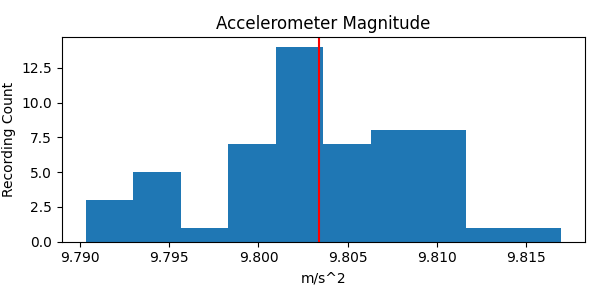

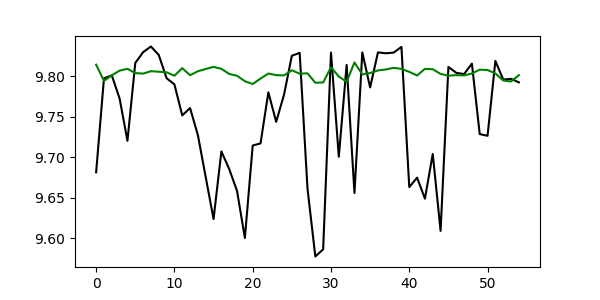

In [11]:
# Calculate the Error for the original
mag_a_mean_list = np.array([np.linalg.norm(cal_a) for cal_a in a_mean_list])
errors = mag_a_mean_list - tools.GRAVITY
print(f"Error: {np.mean(errors):0.4} ± {np.std(errors):0.4} (original)")

# Using the accelerometer offsets, let's plot a histogram of the norm of the accelerometer
adjusted_a_mean_list = np.array([np.linalg.norm(cal_a) for cal_a in calibrated_accelerometer])
errors = adjusted_a_mean_list - tools.GRAVITY
print(f"Mean norm: {np.mean(adjusted_a_mean_list):0.4f}")
print(f"RMS error: {np.sqrt(np.mean((errors)**2)):0.4f}")
print(f"Error: {np.mean(errors):0.4} ± {np.std(errors):0.4} ({sensitivity_type})")

# Plot a histogram of the norm of the accelerometer
plt.figure(figsize=(6, 3))
plt.hist(adjusted_a_mean_list, bins=10)
plt.axvline(tools.GRAVITY, color='r', label='Target')
plt.title('Accelerometer Magnitude')
plt.xlabel('m/s^2')
plt.ylabel('Recording Count')
plt.tight_layout()
plt.show()

# Plot the errors using a line plot
plt.figure(figsize=(6, 3))
plt.plot([np.linalg.norm(a) for a in a_mean_list], 'k')
plt.plot(adjusted_a_mean_list, 'g')
plt.show()

# 5V Error: -0.05432 ± 0.0744 (original)
# 5V Error: -8.674e-05 ± 0.02928 (single)
# 5V Error: -4.114e-05 ± 0.02036 (individual)
# 5V Error: -1.263e-05 ± 0.005784 (full)

Accelerometer Magnitude vs Temperature: -0.0007 * T + 9.8211


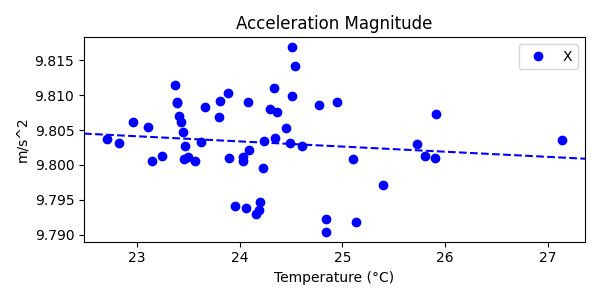

In [12]:
# Calculate the slope and offset of the best fit line for temperature vs accelerometer magnitude
USE_THEIL_SEN = True
if USE_THEIL_SEN:
    x_slope, x_offset, _, _ = stats.theilslopes(adjusted_a_mean_list, t_mean_list)
else:
    x_slope, x_offset = np.polyfit(t_mean_list, adjusted_a_mean_list, 1)

# Print the slope and offset for each axis
print(f'Accelerometer Magnitude vs Temperature: {x_slope:.4f} * T + {x_offset:.4f}')

plt.figure(figsize=(6, 3))
plt.plot(t_mean_list, adjusted_a_mean_list, 'o', label='X', color='blue')
plt.axline((t_mean_list[0], x_slope * t_mean_list[0] + x_offset), slope=x_slope, color='blue', linestyle='--')
plt.title('Acceleration Magnitude')
plt.xlabel('Temperature (°C)')
plt.ylabel('m/s^2')
plt.legend()
plt.tight_layout()
plt.show()

Correlations for G_X > 0.3:
G_X            1.000000
Temperature    0.689460
G_Y            0.640073
G_Z            0.480997
A_X            0.420292
Name: G_X, dtype: float64

Correlations for G_Y > 0.3:
G_Y            1.000000
G_X            0.640073
Temperature    0.547820
G_Z            0.410668
A_Y            0.384540
Name: G_Y, dtype: float64

Correlations for G_Z > 0.3:
G_Z            1.000000
Temperature    0.806888
G_X            0.480997
G_Y            0.410668
A_Z            0.361062
Name: G_Z, dtype: float64

Correlations for A_M > 0.3:
A_M    1.0
Name: A_M, dtype: float64

Correlations for Temperature > 0.3:
Temperature    1.000000
G_Z            0.806888
G_X            0.689460
G_Y            0.547820
A_Z            0.374748
A_Y            0.340891
Name: Temperature, dtype: float64


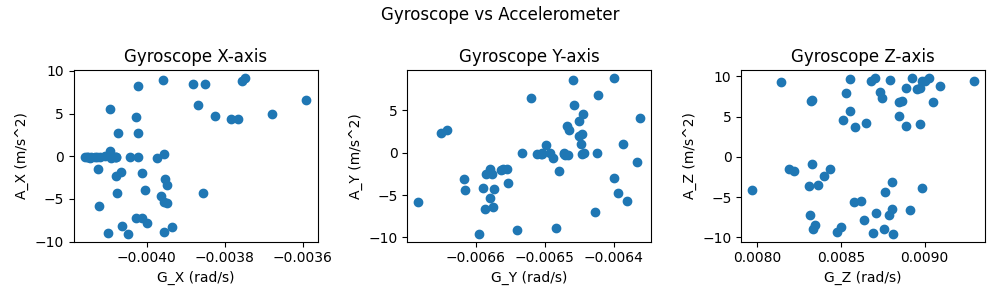

In [15]:
CORRELATE_POST_CALIBRATION = False
# Create a dataframe with the calibrated gyroscope and accelereomter data and filename
if CORRELATE_POST_CALIBRATION:
    calibrated_df = pd.DataFrame(np.hstack((calibrated_accelerometer, calibrated_gyroscope)), columns=['A_X', 'A_Y', 'A_Z', 'G_X', 'G_Y', 'G_Z'])
else:
    calibrated_df = pd.DataFrame(np.hstack((a_mean_list, g_mean_list)), columns=['A_X', 'A_Y', 'A_Z', 'G_X', 'G_Y', 'G_Z'])
# Add temperature and acceleration magnitude
calibrated_df['Temperature'] = t_mean_list
calibrated_df['A_M'] = np.linalg.norm(calibrated_accelerometer, axis=1)

# Calculate the correlation matrix
corr = calibrated_df.corr()

# Get the absolute value of the correlation for G_X, G_Y, and G_Z
abs_corr_G_X = corr['G_X'].abs()
abs_corr_G_Y = corr['G_Y'].abs()
abs_corr_G_Z = corr['G_Z'].abs()
abs_corr_A_M = corr['A_M'].abs()
abs_corr_T = corr['Temperature'].abs()

# Print the values and column where the absolute value is greater than 0.5
print("Correlations for G_X > 0.3:")
print(abs_corr_G_X[abs_corr_G_X > 0.3].sort_values(ascending=False))

print("\nCorrelations for G_Y > 0.3:")
print(abs_corr_G_Y[abs_corr_G_Y > 0.3].sort_values(ascending=False))

print("\nCorrelations for G_Z > 0.3:")
print(abs_corr_G_Z[abs_corr_G_Z > 0.3].sort_values(ascending=False))

print("\nCorrelations for A_M > 0.3:")
print(abs_corr_A_M[abs_corr_A_M > 0.3].sort_values(ascending=False))

print("\nCorrelations for Temperature > 0.3:")
print(abs_corr_T[abs_corr_T > 0.3].sort_values(ascending=False))

# Plot the A_X on the y-axis and G_X on the x-axis, and the other three axis, one subplot for each
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('Gyroscope vs Accelerometer')
for i, (axis_name, axis_data) in enumerate(zip(['X', 'Y', 'Z'], calibrated_gyroscope.T)):
    ax[i].plot(calibrated_df[f'G_{axis_name}'], calibrated_df[f'A_{axis_name}'], 'o')
    ax[i].set_title(f'Gyroscope {axis_name}-axis')
    ax[i].set_xlabel(f'G_{axis_name} (rad/s)')
    ax[i].set_ylabel(f'A_{axis_name} (m/s^2)')
plt.tight_layout()
plt.show()

In [14]:
# Example usage:
ADDITIONAL_CALIBRATION_SUGGESTIONS = 5
plot_pitch_list, plot_roll_list = tools.rotation_to_pitch_and_roll(rotation_list)
plot_color_list = ['blue']*len(plot_pitch_list)
for i in range(ADDITIONAL_CALIBRATION_SUGGESTIONS):
    new_pitch, new_roll = tools.find_largest_gap(plot_pitch_list, plot_roll_list)
    print(f"{i+1}. New Calibration: Pitch = {np.rad2deg(new_pitch):.4f}, Roll = {np.rad2deg(new_roll):.4f}", flush=True)
    # Add the new rotation to the list
    plot_pitch_list.append(new_pitch)
    plot_roll_list.append(new_roll)
    plot_color_list.append('red')
tools.plot_rotations_on_sphere(plot_pitch_list, plot_roll_list, plot_color_list)

1. New Calibration: Pitch = 18.1045, Roll = 75.3157
2. New Calibration: Pitch = 43.8005, Roll = 48.5157
3. New Calibration: Pitch = -144.7605, Roll = -82.8770
4. New Calibration: Pitch = 63.9892, Roll = -90.0000
5. New Calibration: Pitch = -58.3273, Roll = 67.2973
